# IFT6135 Assignment2, Programming part
Names: Xiao Fan (20086722) , Zhibin Lu (20091078)

In [1]:
%pylab inline
import time
import os
import sys
import collections

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms

from_numpy = torch.from_numpy

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
import gzip

Populating the interactive namespace from numpy and matplotlib


# 1. Regularization : weight decay, early stopping, dropout, domain prior knowledge

**Load MNIST dataset**

In [2]:
print('Load MNIST data:')
# Pour l'ensemble de donnees de mnist
mnist_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(
        root='./data', train=True, 
        transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(
        root='./data', train=False, 
        transform=mnist_transforms, download=True)

print('mnist_train:',len(mnist_train))
print('mnist_test:',len(mnist_test))

Load MNIST data:
mnist_train: 60000
mnist_test: 10000


## (a) Early stopping and weight decay
**Build the MLP model**

In [3]:
class MLPnet(nn.Module):

    #todo: init paramater
    def __init__(self,sizes):
        super(MLPnet, self).__init__()

        self.sizes = sizes
        
#         self.loss_criterion = nn.NLLLoss()
        self.loss_criterion = nn.CrossEntropyLoss()
        neu_seq=collections.OrderedDict()
        for i in range(len(sizes)-1):
            neu_seq[str(i*2)]=torch.nn.Linear(self.sizes[i], self.sizes[i+1])
            if i<len(sizes)-2:
                neu_seq[str(i*2+1)]=torch.nn.ReLU()
#         neu_seq[str(i*2+1)]=torch.nn.LogSoftmax()
        
        self.mlp_architecture = torch.nn.Sequential(neu_seq)

    def forward(self, x):
        log_proba_out = self.mlp_architecture(x)
        return log_proba_out
        
    def predict(self, proba_out):
#         return np.argmax(proba_out.data.cpu().numpy(),1)
        _,max_ind=proba_out.max(1)
        return max_ind
    
    def loss(self, log_proba_out, target):
        return self.loss_criterion(log_proba_out, target)

    def adjust_lr(self, optimizer, epoch, total_epochs):
        lr = lr0 * (0.1 ** (epoch / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    def init_weights_zero(self,m):
        if type(m) == nn.Linear:
            nn.init.constant(m.weight, 0.0)

    def init_weights_normal(self,m):
        if type(m) == nn.Linear:
            nn.init.normal(m.weight)

    def init_weights_glorot(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform(m.weight)
            
    def calculate_parameter_norm(self) :
        n = 0
        for i, l in enumerate(self.mlp_architecture):
            if type(l) == nn.Linear :
                n += torch.norm(l.weight,p=2) **2 + torch.norm(l.bias,p=2) **2   
        return float(torch.sqrt(n))

    def evaluate(self, dataset_loader):
        LOSSES = 0
        COUNTER = 0
        ACCURACY=0
        for batch in dataset_loader:
            # optimizer.zero_grad()
            x, y = batch
            x = Variable(x).view(-1,self.sizes[0])
            y = Variable(y).view(-1)
            if cuda:
                x = x.cuda()
                y = y.cuda()
            
            log_proba_out=self.forward(x)
            loss = self.loss(log_proba_out, y)
            predict_out=self.predict(log_proba_out)

            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n

            COUNTER += n
            ACCURACY+=float(torch.eq(predict_out, y).sum().data.cpu().numpy())
        # get average loss
        return ACCURACY / float(COUNTER) ,LOSSES / float(COUNTER)

    def train_model(self, optim_func, lr, momentum, weight_decay, num_epochs, batch_size, train_data, valid_data=None, test_data=None, display=5):

        LOSSES = 0
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_valid = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_valid = list()
        learning_curve_acc_test = list()
        
        parameter_l2_norm = list()

        # separate data to mini batchs.
        train_loader = torch.utils.data.DataLoader(
                train_data, batch_size=batch_size, shuffle=True, num_workers=2)
        if valid_data is not None:
            valid_loader = torch.utils.data.DataLoader(
                valid_data, batch_size=batch_size, shuffle=True, num_workers=2)        
        if test_data is not None:
            test_loader = torch.utils.data.DataLoader(
                test_data, batch_size=batch_size, shuffle=True, num_workers=2)
        

        #training
        print('Training Begining, Count of batchs:',len(train_loader))
        
        # d_p.add_(weight_decay, p.data), 
        weight_decay_per_sample = weight_decay / len(train_data) * batch_size
        optimizer=optim_func(self.parameters(), lr, momentum, weight_decay = weight_decay_per_sample)

        # trainloss_every = 200
        for ep in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
                x = Variable(x).view(-1,self.sizes[0])
                y = Variable(y).view(-1)
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                    
                log_proba_out=self.forward(x)
                loss = self.loss(log_proba_out, y)
                loss.backward()
                optimizer.step()
                parameter_l2_norm.append(self.calculate_parameter_norm())
            
            # record loss values and accuray values
            train_acc,train_loss = self.evaluate(train_loader)
            learning_curve_nll_train.append(train_loss)
            learning_curve_acc_train.append(train_acc)
            if valid_data is not None:
                valid_acc,valid_loss = self.evaluate(valid_loader)
                learning_curve_nll_valid.append(valid_loss)
                learning_curve_acc_valid.append(valid_acc)
            if test_data is not None:
                test_acc,test_loss = self.evaluate(test_loader)
                learning_curve_nll_test.append(test_loss)
                learning_curve_acc_test.append(test_acc)

            # print the process of the training.  
            if display!=0 and (ep % display==0 or ep==(num_epochs-1)):
                if valid_data is None:
                    valid_loss=0
                    valid_acc=0
                if test_data is None:
                    test_loss=0
                    test_acc=0
                print("Epoch:{}, [NLL] TRAIN {} / VALID {} / TEST {}".format(ep+1,
                    train_loss, valid_loss, test_loss))
                print("Epoch:{}, [ACC] TRAIN {} / VALID {} / TEST {}".format(ep+1,
                    train_acc, valid_acc, test_acc))
            
#             self.adjust_lr(optimizer, ep+1, num_epochs)
            
        return learning_curve_nll_train, \
            learning_curve_nll_valid, \
            learning_curve_nll_test, \
            learning_curve_acc_train, \
            learning_curve_acc_valid,\
            learning_curve_acc_test,\
            parameter_l2_norm


### No regularization

In [4]:
sizes=[784,800,800,10]
num_epochs = 100
batch_size = 64
lr0 = 0.02
momentum=0.0
weight_decay = 0
cuda = True

#define mlp net
model1 = MLPnet(sizes)
if cuda:
    model1 = model1.cuda()
    
model1.apply(model1.init_weights_glorot)
ll_train,ll_valid,ll_test,acc_train,acc_valid,acc_test,l2_norm=\
    model1.train_model(torch.optim.SGD, lr0, momentum, weight_decay,
        num_epochs, batch_size, mnist_train,None,mnist_test, 10)

Training Begining, Count of batchs: 938
Epoch:1, [NLL] TRAIN [ 0.30150458] / VALID 0 / TEST [ 0.28974783]
Epoch:1, [ACC] TRAIN 0.9148166666666666 / VALID 0 / TEST 0.9191
Epoch:11, [NLL] TRAIN [ 0.07658689] / VALID 0 / TEST [ 0.09407724]
Epoch:11, [ACC] TRAIN 0.9788333333333333 / VALID 0 / TEST 0.9722
Epoch:21, [NLL] TRAIN [ 0.03629542] / VALID 0 / TEST [ 0.07131872]
Epoch:21, [ACC] TRAIN 0.9915666666666667 / VALID 0 / TEST 0.9778
Epoch:31, [NLL] TRAIN [ 0.01900418] / VALID 0 / TEST [ 0.06254788]
Epoch:31, [ACC] TRAIN 0.9968166666666667 / VALID 0 / TEST 0.9803
Epoch:41, [NLL] TRAIN [ 0.01079048] / VALID 0 / TEST [ 0.06080459]
Epoch:41, [ACC] TRAIN 0.9989333333333333 / VALID 0 / TEST 0.981
Epoch:51, [NLL] TRAIN [ 0.00655173] / VALID 0 / TEST [ 0.06099875]
Epoch:51, [ACC] TRAIN 0.9996166666666667 / VALID 0 / TEST 0.9806
Epoch:61, [NLL] TRAIN [ 0.00425685] / VALID 0 / TEST [ 0.06180353]
Epoch:61, [ACC] TRAIN 0.9999333333333333 / VALID 0 / TEST 0.9812
Epoch:71, [NLL] TRAIN [ 0.00307291] / V

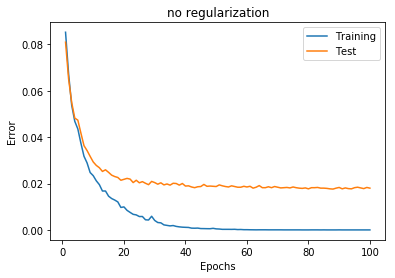

In [5]:
plt.figure()
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_train),label='Training')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_test),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('no regularization')
plt.legend()
plt.savefig('problem1a-error-no-reg.pdf')
plt.show()

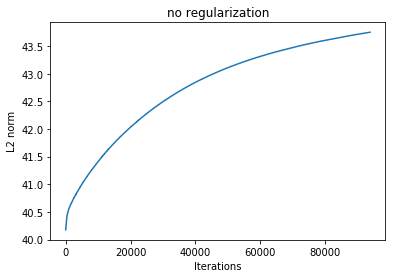

In [6]:
plt.figure()
plt.plot(range(1,len(l2_norm)+1),l2_norm)
plt.xlabel('Iterations')
plt.ylabel('L2 norm')
plt.title('no regularization')
plt.legend()
plt.savefig('problem1a-norm-no-reg.pdf')
plt.show()

### L2 regularization

In [7]:
sizes=[784,800,800,10]
num_epochs = 100
batch_size = 64
lr0 = 0.02
momentum=0.0
cuda = True
weight_decay = 2.5

#define mlp net
model1 = MLPnet(sizes)
if cuda:
    model1 = model1.cuda()
    
model1.apply(model1.init_weights_glorot)
ll_train2,ll_valid2,ll_test2,acc_train2,acc_valid2,acc_test2,l2_norm2=\
    model1.train_model(torch.optim.SGD, lr0, momentum, weight_decay,
        num_epochs, batch_size, mnist_train, None, mnist_test, 10)

Training Begining, Count of batchs: 938
Epoch:1, [NLL] TRAIN [ 0.3101345] / VALID 0 / TEST [ 0.29795945]
Epoch:1, [ACC] TRAIN 0.9136333333333333 / VALID 0 / TEST 0.9164
Epoch:11, [NLL] TRAIN [ 0.11803168] / VALID 0 / TEST [ 0.12609766]
Epoch:11, [ACC] TRAIN 0.9704166666666667 / VALID 0 / TEST 0.9653
Epoch:21, [NLL] TRAIN [ 0.09172269] / VALID 0 / TEST [ 0.10463296]
Epoch:21, [ACC] TRAIN 0.9780833333333333 / VALID 0 / TEST 0.9727
Epoch:31, [NLL] TRAIN [ 0.0834536] / VALID 0 / TEST [ 0.09648997]
Epoch:31, [ACC] TRAIN 0.9806166666666667 / VALID 0 / TEST 0.9734
Epoch:41, [NLL] TRAIN [ 0.07617865] / VALID 0 / TEST [ 0.08971363]
Epoch:41, [ACC] TRAIN 0.9833166666666666 / VALID 0 / TEST 0.9769
Epoch:51, [NLL] TRAIN [ 0.07335868] / VALID 0 / TEST [ 0.08886386]
Epoch:51, [ACC] TRAIN 0.9844 / VALID 0 / TEST 0.9767
Epoch:61, [NLL] TRAIN [ 0.07101085] / VALID 0 / TEST [ 0.08591261]
Epoch:61, [ACC] TRAIN 0.9851 / VALID 0 / TEST 0.9769
Epoch:71, [NLL] TRAIN [ 0.07085043] / VALID 0 / TEST [ 0.0863973

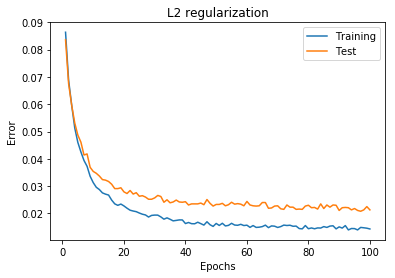

In [8]:
plt.figure()
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_train2),label='Training')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_test2),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('L2 regularization')
plt.legend()
plt.savefig('problem1a-error-l2-reg.pdf')
plt.show()

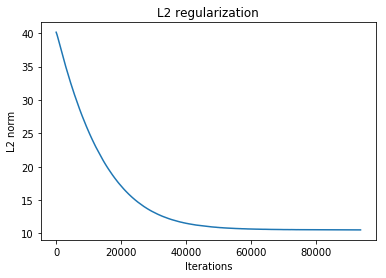

In [9]:
plt.figure()
plt.plot(range(1,len(l2_norm)+1),l2_norm2)
plt.xlabel('Iterations')
plt.ylabel('L2 norm')
plt.title('L2 regularization')
plt.legend()
plt.savefig('problem1a-norm-l2-reg.pdf')
plt.show()

### compare effect of L2 regularisation

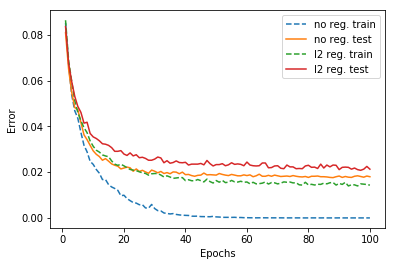

In [10]:
plt.figure()
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_train), linestyle='--',label='no reg. train')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_test),label='no reg. test')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_train2),linestyle='--',label='l2 reg. train')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_test2),label='l2 reg. test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.savefig('problem1a-error.pdf')
plt.show()

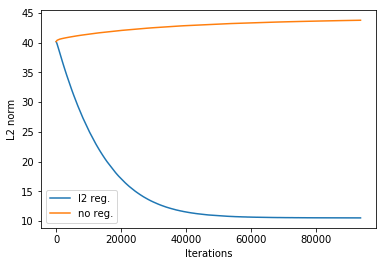

In [11]:
plt.figure()
plt.plot(range(1,len(l2_norm2)+1),l2_norm2,label='l2 reg.')
plt.plot(range(1,len(l2_norm)+1),l2_norm,label='no reg.')
plt.xlabel('Iterations')
plt.ylabel('L2 norm')
plt.legend()
plt.savefig('problem1a-l2-norm.pdf')
plt.show()

## (b) Dropout

In [6]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

print('mnist_train:',len(mnist_train))
print('mnist_test:',len(mnist_test))

('mnist_train:', 60000)
('mnist_test:', 10000)


In [7]:
# build the model
class MLP_dropout(nn.Module):
    """MLP with dropout"""
    def __init__(self):
        super(MLP_dropout, self).__init__()
        self.net = nn.Sequential(

            nn.Linear(784,800),
            nn.ReLU(),
            nn.Linear(800,800),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(800,10)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
# train the model
cuda = torch.cuda.is_available()
model = MLP_dropout()
if cuda:
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
criterion = nn.NLLLoss()
logsoft = nn.LogSoftmax()

acc_train = list()
acc_test = list()

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

for epoch in range(100):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        optimizer.zero_grad()
        inputs = Variable(inputs).view(-1,784)
        targets =  Variable(targets).view(-1)
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = logsoft(model.forward(inputs))
        loss = criterion(outputs, targets) #-x[class]
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

/Users/fanxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 0 Loss : 1.028 
Epoch : 1 Loss : 0.379 
Epoch : 2 Loss : 0.307 
Epoch : 3 Loss : 0.262 
Epoch : 4 Loss : 0.229 
Epoch : 5 Loss : 0.203 
Epoch : 6 Loss : 0.181 
Epoch : 7 Loss : 0.164 
Epoch : 8 Loss : 0.150 
Epoch : 9 Loss : 0.136 
Epoch : 10 Loss : 0.126 
Epoch : 11 Loss : 0.117 
Epoch : 12 Loss : 0.108 
Epoch : 13 Loss : 0.101 
Epoch : 14 Loss : 0.095 
Epoch : 15 Loss : 0.089 
Epoch : 16 Loss : 0.083 
Epoch : 17 Loss : 0.078 
Epoch : 18 Loss : 0.073 
Epoch : 19 Loss : 0.069 
Epoch : 20 Loss : 0.066 
Epoch : 21 Loss : 0.062 
Epoch : 22 Loss : 0.058 
Epoch : 23 Loss : 0.055 
Epoch : 24 Loss : 0.053 
Epoch : 25 Loss : 0.049 
Epoch : 26 Loss : 0.047 
Epoch : 27 Loss : 0.046 
Epoch : 28 Loss : 0.044 
Epoch : 29 Loss : 0.041 
Epoch : 30 Loss : 0.040 
Epoch : 31 Loss : 0.037 
Epoch : 32 Loss : 0.036 
Epoch : 33 Loss : 0.034 
Epoch : 34 Loss : 0.033 
Epoch : 35 Loss : 0.031 
Epoch : 36 Loss : 0.029 
Epoch : 37 Loss : 0.028 
Epoch : 38 Loss : 0.027 
Epoch : 39 Loss : 0.026 
Epoch : 40

### Evaluate the model with three schemes

In [12]:

# multiply 0.5 to the hidden layer before prediction
# Evaluate
def evaluate1 ():
    testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)
    model.eval()
    
    count = 0
    acc_test = 0
    for batch_idx, (inputs, targets) in enumerate(testloader): 
    
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        inputs = Variable(inputs).view(-1,784)
        targets = Variable(targets).view(-1)
        outputs = logsoft(model.forward(inputs))  
    
        _, predicted = torch.max(outputs.data, 1)
    
        count += targets.size(0)
        acc_test += predicted.eq(targets.data).cpu().sum()     
    
    acc_test = acc_test/(count*1.0)
    print('No mask, Test Acc : %.3f' % (100.*acc_test))  #Test Acc : 98.360
    print('--------------------------------------------------------------')
    return 100.*acc_test


#%%

# Sample N dropout masks , average before softmax
def evaluate2(num_mask) : 
    testloader = torch.utils.data.DataLoader(mnist_test, batch_size = len(mnist_test), shuffle=False, num_workers=2)
    N = num_mask
    outputs = torch.zeros(len(mnist_test),10)
    model.train()
    for mask in range(N) :
        for batch_idx, (inputs, targets) in enumerate(testloader): 
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
        
            inputs = Variable(inputs).view(-1,784)
            targets = Variable(targets).view(-1)
            outputs.add_(model.forward(inputs).data)
            
    #outputs = outputs/(1.0*N)
    _,predicted = torch.max(outputs/(1.0 * N),1)
    acc_test = predicted.eq(targets.data).cpu().sum()/(1.0*len(mnist_test))
    
    print('Pre-softmax, %d masks, Test Acc : %.3f' % ( N, 100.*acc_test))
    print('--------------------------------------------------------------')
    return 100.*acc_test
    

#%%
# Sample N dropout masks , make a prediction and take the average
def evaluate3(num_mask):
    testloader = torch.utils.data.DataLoader(mnist_test, batch_size = len(mnist_test), shuffle=False, num_workers=2)
    N = num_mask
    outputs = torch.zeros(len(mnist_test),10)
    model.train()
    for mask in range(N) :
        for batch_idx, (inputs, targets) in enumerate(testloader): 
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
        
            inputs = Variable(inputs).view(-1,784)
            targets = Variable(targets).view(-1)
            outputs.add_(logsoft(model.forward(inputs)).data)
            
    _,predicted = torch.max(outputs/(1.0 * N),1)
    acc_test = predicted.eq(targets.data).cpu().sum()/(1.0*len(mnist_test))

    print('Post-softmax, %d masks, Test Acc : %.3f' % (N, 100.*acc_test))
    print('--------------------------------------------------------------')
    return 100.*acc_test

In [13]:
pred1 = np.ones(10)*evaluate1()
pred2 = []
pred3 = []

for N in range(10,110,10) :
    pred2.append(evaluate2(N))
    pred3.append(evaluate3(N))

/Users/fanxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


No mask, Test Acc : 98.270
--------------------------------------------------------------
Pre-softmax, 10 masks, Test Acc : 98.190
--------------------------------------------------------------


/Users/fanxiao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Post-softmax, 10 masks, Test Acc : 98.260
--------------------------------------------------------------
Pre-softmax, 20 masks, Test Acc : 98.340
--------------------------------------------------------------
Post-softmax, 20 masks, Test Acc : 98.280
--------------------------------------------------------------
Pre-softmax, 30 masks, Test Acc : 98.240
--------------------------------------------------------------
Post-softmax, 30 masks, Test Acc : 98.250
--------------------------------------------------------------
Pre-softmax, 40 masks, Test Acc : 98.240
--------------------------------------------------------------
Post-softmax, 40 masks, Test Acc : 98.220
--------------------------------------------------------------
Pre-softmax, 50 masks, Test Acc : 98.310
--------------------------------------------------------------
Post-softmax, 50 masks, Test Acc : 98.280
--------------------------------------------------------------
Pre-softmax, 60 masks, Test Acc : 98.280
------------------

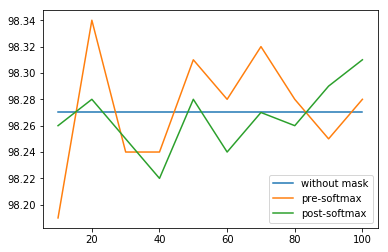

In [14]:
plt.figure()
plt.plot(range(10,110,10),pred1,label='without mask')
plt.plot(range(10,110,10),pred2,label='pre-softmax')
plt.plot(range(10,110,10),pred3,label='post-softmax')
plt.legend()
plt.savefig('problem1b.pdf')
plt.show()

## (c) Convolutional Networks
** Define the cnn model without batch normalisation**

In [15]:
class CNN_Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())



### train cnn classifier without batch normalization

In [16]:

'''
train cnn classifier without batch normalization
'''
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

cuda_available = torch.cuda.is_available()
model_cnn = CNN_Classifier()
if cuda_available:
    model_cnn = model_cnn.cuda()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_train = list()
acc_test = list()

for epoch in range(10):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model_cnn(inputs)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    model_cnn.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_train.append(correct/total)
    print('Epoch : %d Train Acc : %.3f' % (epoch, 100.*correct/total))

    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_test.append(correct/total)

    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    model_cnn.train()


Epoch : 0 Loss : 0.847 
Epoch : 0 Train Acc : 90.768
Epoch : 0 Test Acc : 90.837
--------------------------------------------------------------
Epoch : 1 Loss : 0.230 
Epoch : 1 Train Acc : 94.892
Epoch : 1 Test Acc : 94.923
--------------------------------------------------------------
Epoch : 2 Loss : 0.151 
Epoch : 2 Train Acc : 96.227
Epoch : 2 Test Acc : 96.233
--------------------------------------------------------------
Epoch : 3 Loss : 0.117 
Epoch : 3 Train Acc : 97.137
Epoch : 3 Test Acc : 97.154
--------------------------------------------------------------
Epoch : 4 Loss : 0.095 
Epoch : 4 Train Acc : 97.448
Epoch : 4 Test Acc : 97.471
--------------------------------------------------------------
Epoch : 5 Loss : 0.082 
Epoch : 5 Train Acc : 97.585
Epoch : 5 Test Acc : 97.616
--------------------------------------------------------------
Epoch : 6 Loss : 0.071 
Epoch : 6 Train Acc : 97.825
Epoch : 6 Test Acc : 97.850
-------------------------------------------------------

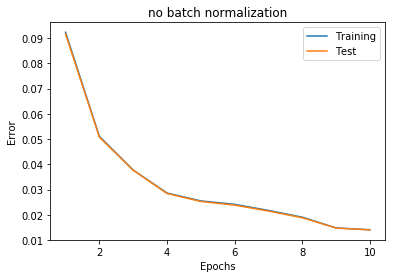

In [17]:
plt.figure()
plt.plot(range(1,11),1.0-np.array(acc_train),label='Training')
plt.plot(range(1,11),1.0-np.array(acc_test),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('no batch normalization')
plt.legend()
plt.savefig('problem1c-no-bn.pdf')
plt.show()

** Define the cnn model with batch normalization **

In [18]:

'''
train cnn classifier with batch normalization
'''
class CNN_BN_Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(CNN_BN_Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32)  ,          
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)
#         self.bn = nn.BatchNorm1d(10)

    def forward(self, x):
#         return self.bn(self.clf(self.conv(x).squeeze()))
        return self.clf(self.conv(x).squeeze())

### train cnn classifier with batch normalization

In [19]:
### train cnn classifier 
cuda_available = torch.cuda.is_available()
model_cnn2 = CNN_BN_Classifier()
if cuda_available:
    model_cnn2 = model_cnn2.cuda()
optimizer = torch.optim.Adam(model_cnn2.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_train = list()
acc_test = list()

for epoch in range(10):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model_cnn2(inputs)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    model_cnn2.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_train.append(correct/total)
    print('Epoch : %d Train Acc : %.3f' % (epoch, 100.*correct/total))

    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_test.append(correct/total)

    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    model_cnn2.train()


Epoch : 0 Loss : 0.503 
Epoch : 0 Train Acc : 97.453
Epoch : 0 Test Acc : 97.466
--------------------------------------------------------------
Epoch : 1 Loss : 0.094 
Epoch : 1 Train Acc : 98.597
Epoch : 1 Test Acc : 98.583
--------------------------------------------------------------
Epoch : 2 Loss : 0.054 
Epoch : 2 Train Acc : 99.053
Epoch : 2 Test Acc : 99.013
--------------------------------------------------------------
Epoch : 3 Loss : 0.038 
Epoch : 3 Train Acc : 99.370
Epoch : 3 Test Acc : 99.316
--------------------------------------------------------------
Epoch : 4 Loss : 0.029 
Epoch : 4 Train Acc : 99.563
Epoch : 4 Test Acc : 99.491
--------------------------------------------------------------
Epoch : 5 Loss : 0.023 
Epoch : 5 Train Acc : 99.683
Epoch : 5 Test Acc : 99.609
--------------------------------------------------------------
Epoch : 6 Loss : 0.019 
Epoch : 6 Train Acc : 99.752
Epoch : 6 Test Acc : 99.680
-------------------------------------------------------

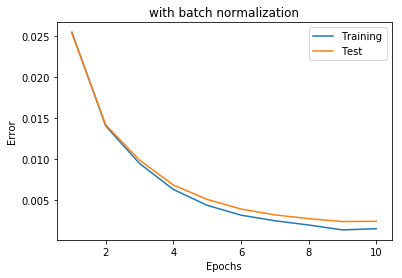

In [20]:
plt.figure()
plt.plot(range(1,11),1.0-np.array(acc_train),label='Training')
plt.plot(range(1,11),1.0-np.array(acc_test),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('with batch normalization')
plt.legend()
plt.savefig('problem1c-with-bn.pdf')
plt.show()